In [1]:
import re
import datetime
from itertools import product
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from collections import Counter


import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from pandas.plotting import table
pd.set_option('max_colwidth', None) # show all text in a column
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.options.display.float_format = '{:,.0f}'.format

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')


import seaborn as sns
# Set Seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("pastel")


from utils import clean_data, preprocess, remove_url, detect_language, dataframe_table_to_png

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isaacduong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isaacduong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isaacduong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isaacduong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
BMBF = pd.read_csv("../results/clustersBMBF.csv")

In [3]:
# dataframe contains only enriched grants
enriched_records = BMBF.loc[BMBF["Thema"].str.strip()!=BMBF["enriched_Thema"].str.strip(),:]

In [4]:
enriched_records

,FKZ,Ressort,Referat,PT,Arb.-Einh.,Zuwendungsempfänger,Gemeindekennziffer,Stadt/Gemeinde,Ort,Bundesland,Staat,Ausführende Stelle,Gemeindekennziffer.1,Stadt/Gemeinde.1,Ort.1,Bundesland.1,Staat.1,Thema,Leistungsplansystematik,Klartext Leistungsplansystematik,Laufzeit von,Laufzeit bis,Fördersumme in EUR,Förderprofil,Verbundprojekt,Förderart,AWARD,crossref_enrichment,enriched_Thema,Thema-3-0.3,Thema-3-0.5,Thema-3-0.7,Thema-5-0.3,Thema-5-0.5,Thema-5-0.7,Thema-7-0.3,Thema-7-0.5,Thema-7-0.7,enriched_Thema-3-0.3,enriched_Thema-3-0.5,enriched_Thema-3-0.7,enriched_Thema-5-0.3,enriched_Thema-5-0.5,enriched_Thema-5-0.7,enriched_Thema-7-0.3,enriched_Thema-7-0.5,enriched_Thema-7-0.7
90671,01GI0205,BMBF,614,PT-DLR,GF,Charité - Universitätsmedizin Berlin,"11,000,000",Berlin,Berlin,Berlin,Deutschland,Charité - Universitätsmedizin Berlin - Campus Virchow-Klinikum - Medizinische Klinik mit Schwerpunkt Kardiologie,"11,000,000",Berlin,Berlin,Berlin,Deutschland,Kompetenznetz Herzinsuffizienz,AA0130,Herz-Kreislauf,01.01.2003,30.04.2012,"16.437.684,00",Technologie- und Innovationsförderung,NaN,PDIR,01GI0205,Erfassung des subjektiven körperlichen Wohlbefindens bei Herzinsuffizienz,Kompetenznetz Herzinsuffizienz Erfassung des subjektiven körperlichen Wohlbefindens bei Herzinsuffizienz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106137,01JH0901,BMBF,321,PT-DLR,BI,Universität Mannheim,"8,222,000",Mannheim,Mannheim,Baden-Württemberg,Deutschland,Universität Mannheim - Fakultät für Sozialwissenschaften - Lehrstuhl Pädagogische Psychologie,"8,222,000",Mannheim,Mannheim,Baden-Württemberg,Deutschland,"Verbundvorhaben: Berufliche Zielorientierungen von Lehrkräften: Entwicklungsbedingungen, Auswirkungen auf berufliche Kompetenzentwicklung, Effekte auf instruktionales Verhalten sowie Lernprozesse und Lernergebnisse von Schülern, Teilprojekt Mannheim",OB5100,Bildungsforschung,01.06.2009,31.12.2015,"501.715,00",Forschung und Entwicklung zur Daseinsvorsorge,Berufliche Zielorientierungen von Lehrkräften,PDIR,01JH0901,Evaluation eines Interventionsansatzes zur Verbesserung von Motivation und motivationsförderlichem Unterrichtshandeln von Lehrkräften auf Basis der Zielorientierungstheorie,"Verbundvorhaben: Berufliche Zielorientierungen von Lehrkräften: Entwicklungsbedingungen, Auswirkungen auf berufliche Kompetenzentwicklung, Effekte auf instruktionales Verhalten sowie Lernprozesse und Lernergebnisse von Schülern, Teilprojekt Mannheim Evaluation eines Interventionsansatzes zur Verbesserung von Motivation und motivationsförderlichem Unterrichtshandeln von Lehrkräften auf Basis der Zielorientierungstheorie",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108617,01GS08104,BMBF,613,PT-DLR,GF,Technische Universität Dortmund,"5,913,000",Dortmund,Dortmund,Nordrhein-Westfalen,Deutschland,Technische Universität Dortmund - Fakultät für Chemie und Chemische Biologie,"5,913,000",Dortmund,Dortmund,Nordrhein-Westfalen,Deutschland,"Verbundprojekt: Onkogen, Anteil Technische Universität Dortmund (Teilprojekt 5 und 6b)",AA0210,Medizinische Genom- und Postgenomforschung,01.06.2008,31.01.2014,"626.858,00",Technologie- und Innovationsförderung,NGFN-Plus-Krebs-Onkogene,PDIR,01GS08104,"Kovalent‐allosterische Kinase‐Inhibitoren AbstractProteinkinasen repräsentieren wichtige Knotenpunkte intrazellulärer Signalwege und sind somit an vielen physiologischen und pathologischen Prozessen beteiligt. Konformations‐abhängige Eigenschaften dienen hierbei der Feinregulation ihrer enzymatischen Aktivität und Katalyse‐unabhängigen Funktionen. Die Stabilisierung definierter Konformationen ermöglicht detaillierte Analysen solcher Konformations‐abhängiger Funktionen. Hier beschreiben wir das strukturbasierte Design, die Synthese und die Charakterisierung Pleckstrin‐Homologie(PH)‐Domänen‐abhängiger Akt‐Inhibitoren, die einen neuartigen kovalent‐allosterischen Bindungsmodus aufweisen. Durch die kovalente Modifizierung bestimmter Cysteine stabilisieren diese Moleküle die inaktive Kinasekonformation irreversibel. Ihre beträchtlich

In [5]:
def plot_pie_chart(df, col_names):
    
    """ function to create a pie plot comparing the word count before and after data enrichment"""
    
    
    sns.set_palette("Paired") 
    # Preprocess text in each column
    preprocessed_text = df[col_names].apply(lambda col: ' '.join(col.astype(str).values)).apply(preprocess)

    # Calculate the total word count for each column after preprocessing
    total_word_count = preprocessed_text.apply(len)
    total_word_count["enriched_Thema"]=total_word_count["enriched_Thema"]-total_word_count["Thema"]

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    
    startangle = 140 if df.shape[0] < 200 else 0
    plt.pie(total_word_count, labels=["research topics","enriched research topics"], autopct='%1.1f%%', startangle=startangle)
    
    data_table = "total BMBF" if df.shape[0] > 200 else "169 enriched"
    
    plt.title(f'Percentage of word count of {data_table} research topics')


    plt.show()



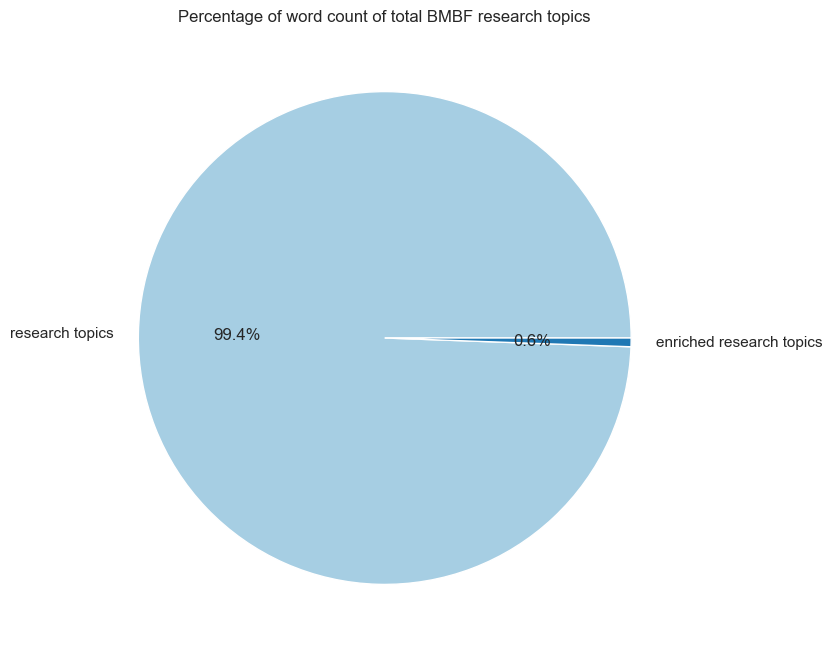

In [6]:
plot_pie_chart(BMBF, ["Thema", "enriched_Thema"])

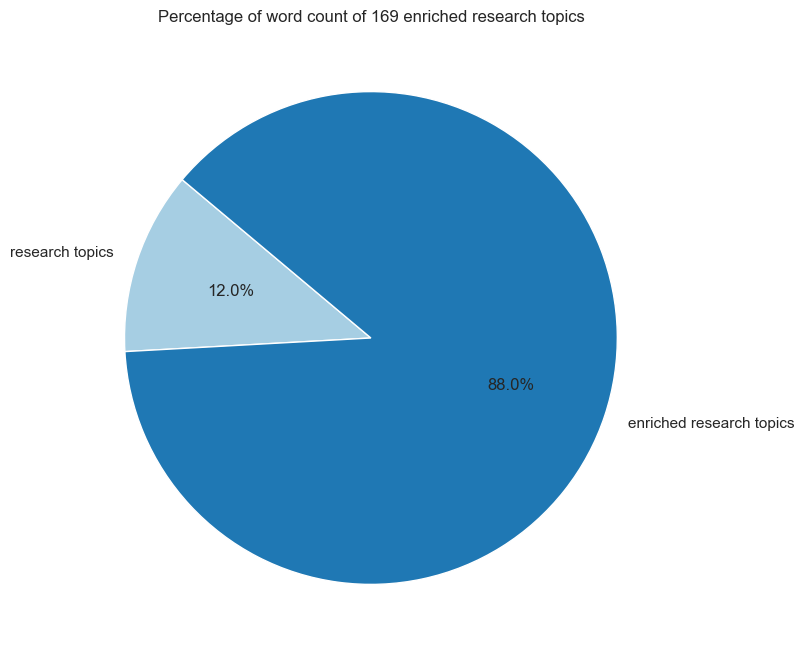

In [7]:
plot_pie_chart(enriched_records, ["Thema", "enriched_Thema"])

In [26]:
def plot_word_count_comparison(df, col_names):
    
    """ function to create bar chart comparing the 30 most common words before and after data enrichment"""
    most_common_words = dict()
    df_dict = dict()
    
    fig, ax = plt.subplots(figsize=(18, 12))
    for i, col in enumerate(col_names):
        text = ' '.join(df[col].astype(str).values)
        stems = preprocess(text)
        dimensions = len(set(stems))

        # Calculate average length
        avg_length = df[col].apply(lambda x: len(str(x).split())).mean()
        avg_length = round(avg_length)

        # Calculate total word count
        total_word_count = len(text.split())

        enrichment_status = "after" if "enrich" in col else "before"
        data_table = "entire BMBF" if df.shape[0] > 200 else "169 enriched"
        
        plotkind= "barh" if df.shape[0] > 200 else "bar"
        loc = -1.0 if df.shape[0] > 200 else -1.4
        if df.shape[0] < 200:
            ax.tick_params(axis='x', rotation=45)
    
        color ="#87CEEB"   if i == 0  else "darkblue"
        col_en = "research topics" if col=="Thema" else "enriched research topics"
        
        
        ax.text(loc,i/20 + 1.05 ,f"average length of {col_en}: {avg_length}",  color=color, fontsize=22)
        ax.text(loc,i/20 + 0.9, f"total word count of {col_en}: {total_word_count}", color=color,fontsize=22)
        ax.text(loc,i/20 + 0.75, f"number of distinct words within {col_en}: {dimensions}",  color=color,fontsize=22)
        


        word_counts = Counter(stems)
        most_common_words[col] = word_counts.most_common(30)
    
        df_dict[col] = pd.DataFrame(most_common_words[col], columns=["word", f"count_{col_en}"])

    df_combined_most_common = pd.merge(df_dict[col_names[0]], df_dict[col_names[1]], on="word", how="outer").fillna(0)

    df_combined_most_common.set_index("word").plot(kind=plotkind, color=["#87CEEB","darkblue"], ax=ax)
    

    plt.tight_layout()
    plt.show()




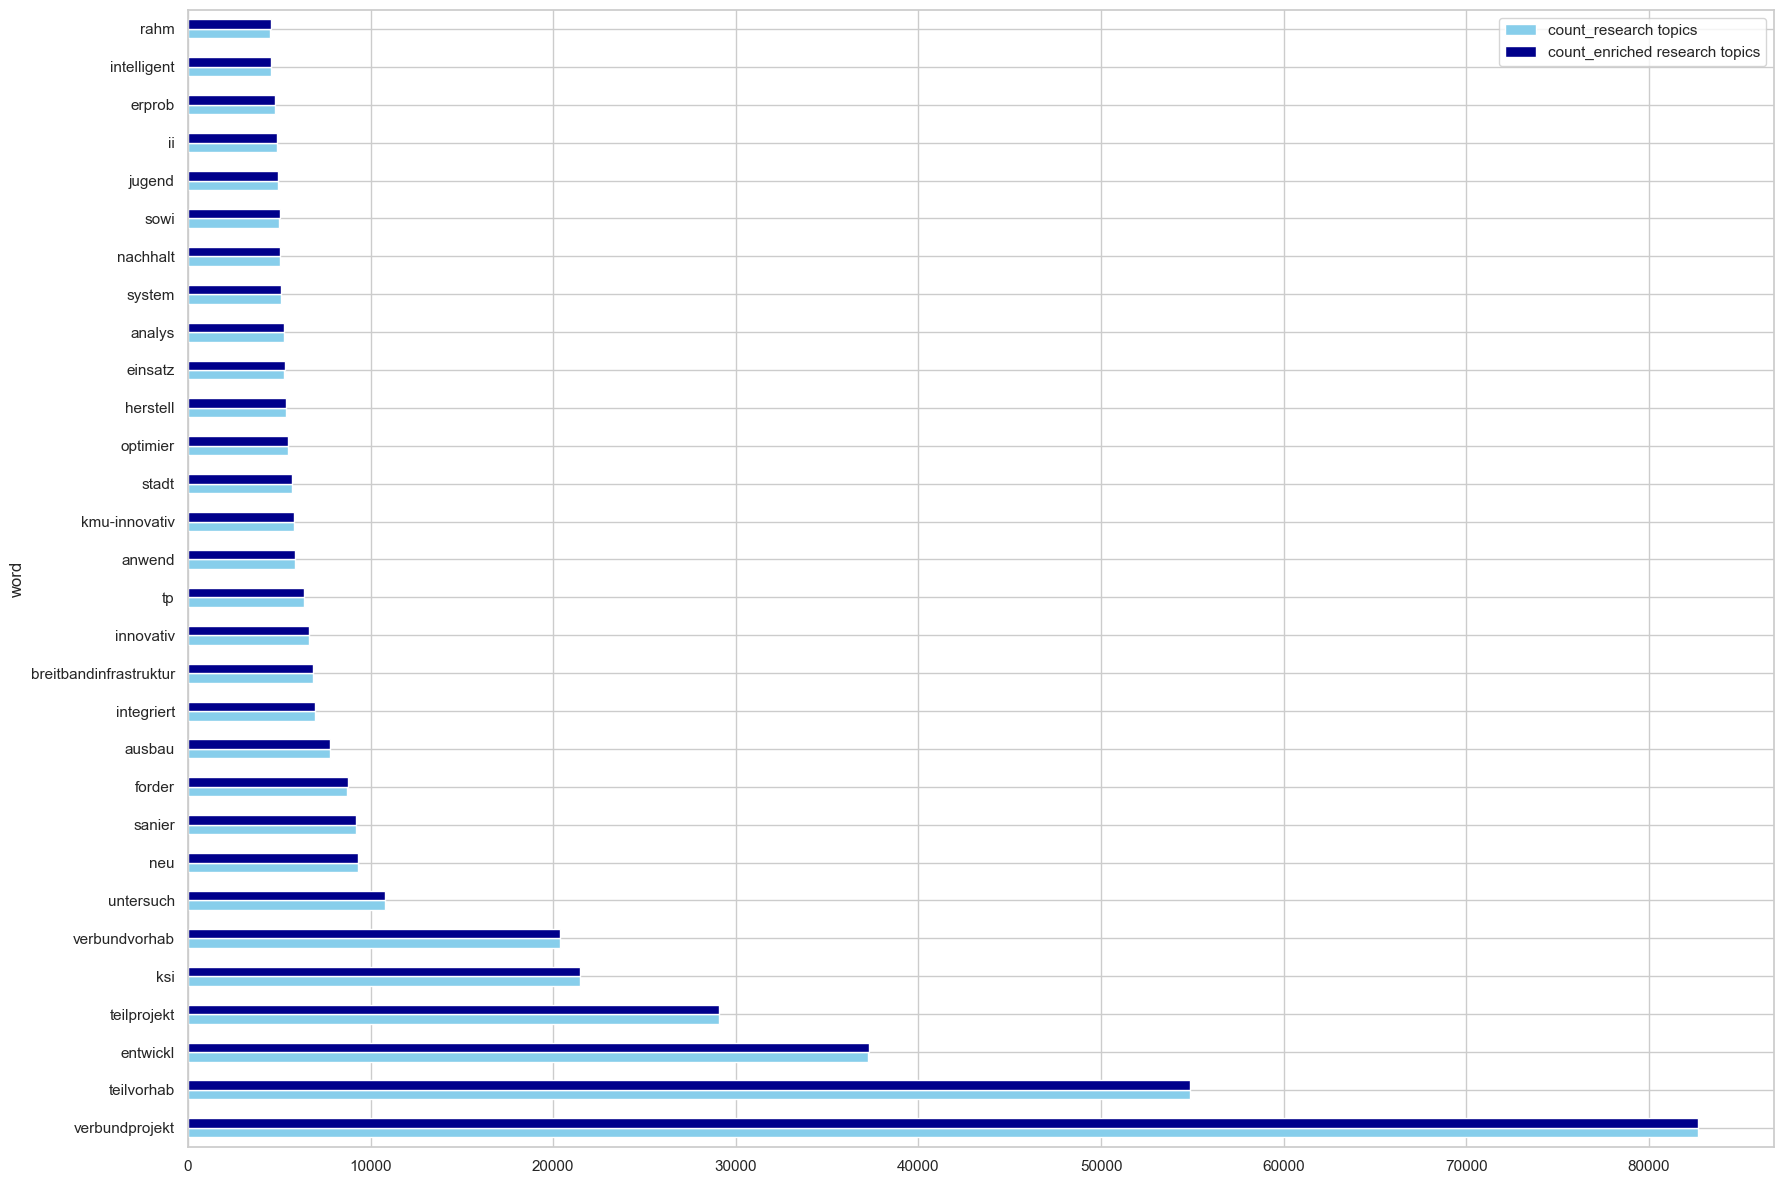

In [28]:
plot_word_count_comparison(BMBF, ["Thema", "enriched_Thema"])

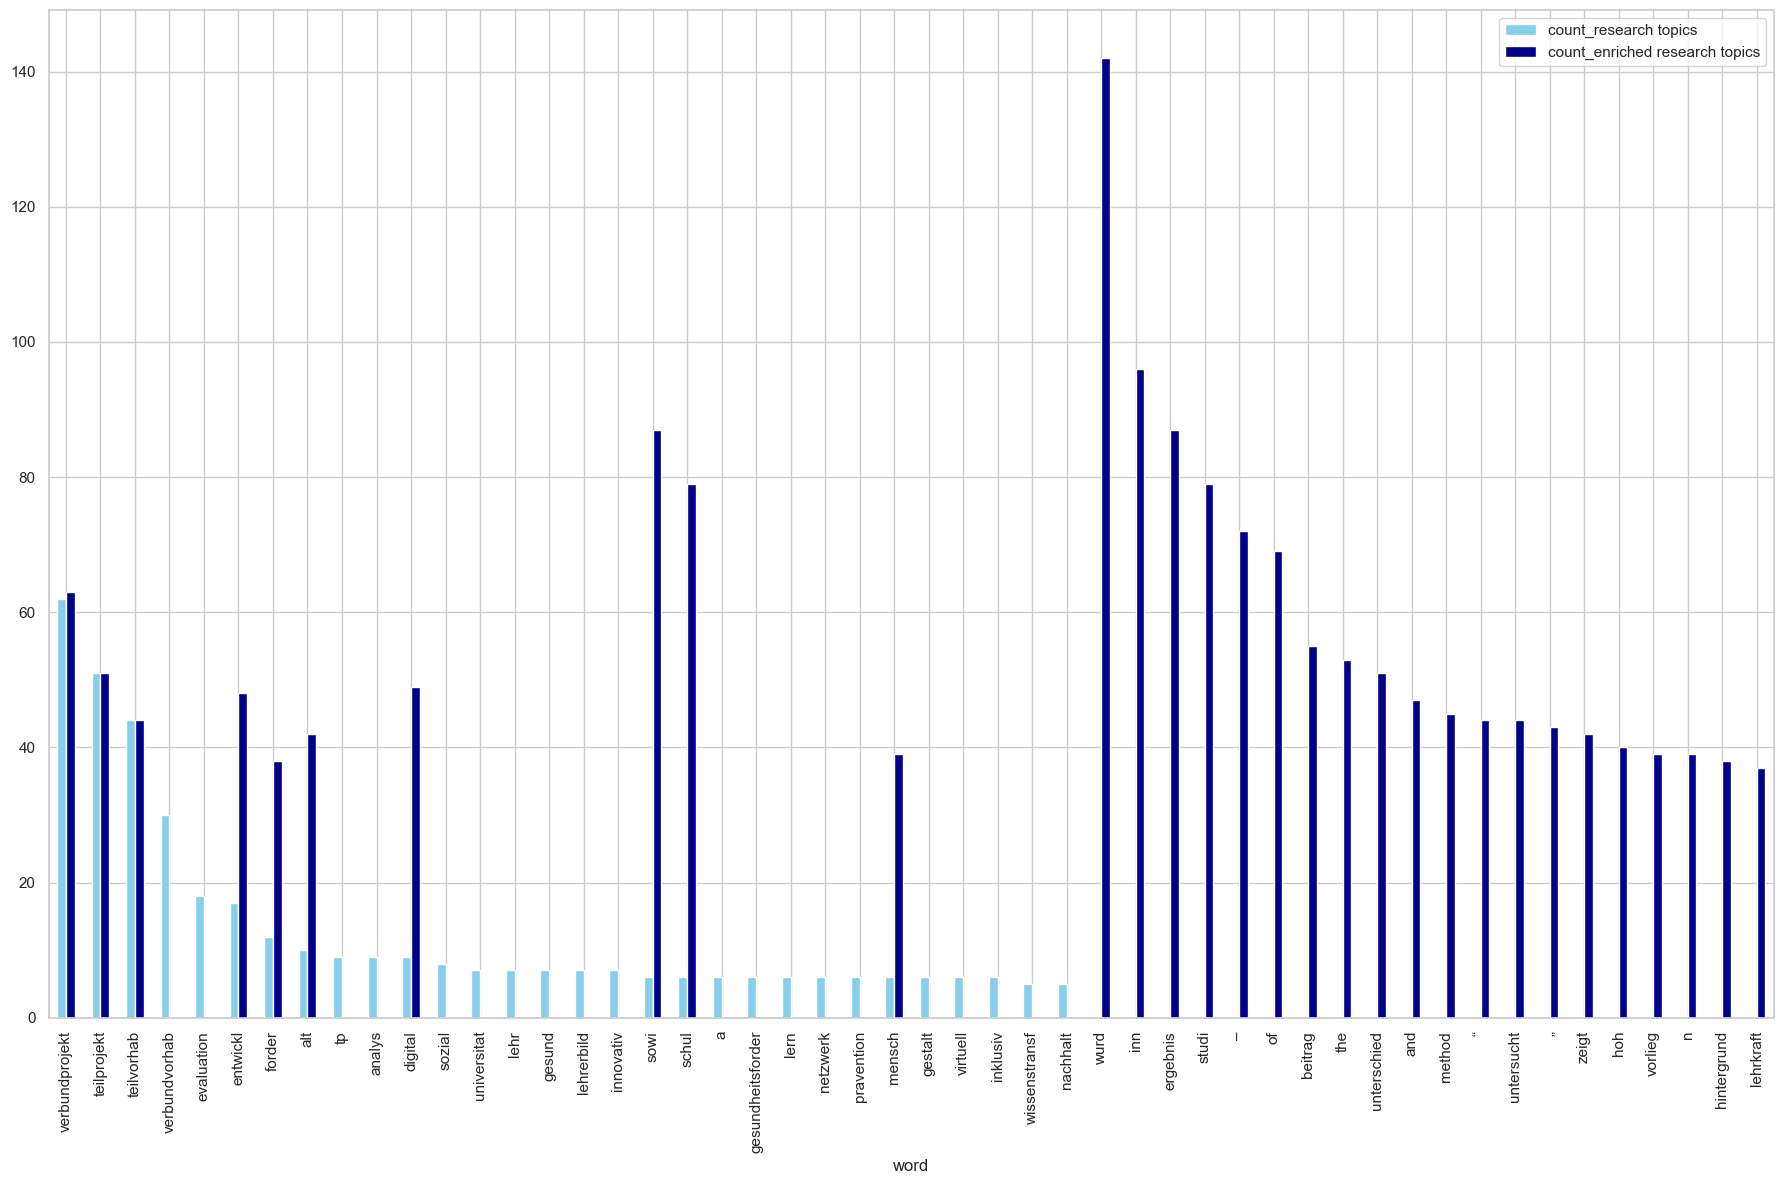

In [29]:
plot_word_count_comparison(enriched_records, ["Thema", "enriched_Thema"])

In [33]:
def get_groups_each_FKZ(groups):
    """ get a dictionary of clusters from subset, keys are cluster labels and values are list of the FKZs belonging to this group""",
    KFZ_groups = dict()
    for FKZ in enriched_records["FKZ"].tolist():
        for key in groups:
            if FKZ in groups[key]:
                KFZ_groups[FKZ] = key 
    
    return KFZ_groups
            

In [34]:
KFZ_groups = get_groups_each_FKZ(topics_groups)
KFZ_enriched_groups = get_groups_each_FKZ(enriched_topics_groups)

In [35]:
subset = pd.DataFrame(list(KFZ_groups.items()), columns=['Grant_ID', 'group_label'])

In [36]:
# group allocation of 169 enriched research topics before enrichment
subset["group_label"].value_counts()

group_label
 0       152
-1        10
 775       1
 912       1
 636       1
 969       1
 996       1
 1023      1
 1553      1
Name: count, dtype: int64

In [37]:
enriched_subset = pd.DataFrame(list(KFZ_enriched_groups.items()), columns=['Grant_ID', 'group_label'])

In [38]:
# group allocation of 169 enriched research topics after enrichment
enriched_subset['group_label'].value_counts()

group_label
-1       87
 0       77
 776      1
 918      1
 971      1
 976      1
 1000     1
Name: count, dtype: int64

In [40]:
concat_df = pd.concat([subset.set_index("Grant_ID"),enriched_subset.set_index("Grant_ID")],axis=1)
concat_df.columns=["group before enrichment", "group after enrichment"]

In [100]:
def plot_cluster_allocation():
    """ function to lot the cluster allocation befor and after data enrichment"""
    from matplotlib.patches import Patch
    ax = concat_df.value_counts(ascending=True).plot(kind="barh", color= "lightgreen");

    # Set the color of a specific bar (e.g., set the color of the bar with value 20 to red)
    ax.patches[11].set_facecolor('red')
    ax.patches[7].set_facecolor('red')
    ax.patches[6].set_facecolor('red')
    ax.patches[1].set_facecolor('red')
    ax.patches[10].set_facecolor('blue')
    ax.patches[9].set_facecolor('blue')
    ax.patches[2].set_facecolor('lightblue')
    ax.patches[3].set_facecolor('lightblue')
    ax.patches[4].set_facecolor('lightblue')
    ax.patches[5].set_facecolor('lightblue')
  
    legend_elements = [
        Patch(color='red', label='Transition into noise points'),
        Patch(color='lightgreen', label='Relocate to other clusters'),
        Patch(color='blue', label='Remain in same clusters'),
        Patch(color='lightblue', label='labels have changed,\nbut same cluster members\nthus denote same cluster')
    ]
    # Annotate the bar heights on top of each bar
    for rect in ax.patches:
        width = rect.get_width()
        ax.annotate(f'{int(width)}', xy=(width, rect.get_y() + rect.get_height() / 2), xytext=(5, 0),
                    textcoords="offset points", ha='left', va='center')

    # Add the legend to the plot
    ax.legend(handles=legend_elements, loc='lower right')

    plt.show()


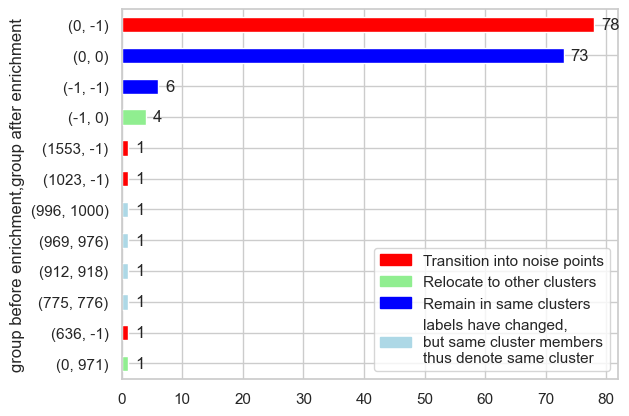

In [101]:
plot_cluster_allocation()

In [96]:
# other label after data enrichment but denote same cluster
BMBF.loc[BMBF["Thema-3-0.3"] == 996,"Thema"]

153320    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
153982    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
154208    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
154591    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
Name: Thema, dtype: object

In [95]:
BMBF.loc[BMBF["enriched_Thema-3-0.3"] == 1000,"Thema"]

153320    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
153982    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
154208    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
154591    Polinom - Polyvalente Trennung durch flexible Integration aktiver Oberflächen in Membranen
Name: Thema, dtype: object

In [30]:
def get_group_indexes(df, labels_column ):
    
    """ function to get cluster label count"""
    topics_groups = dict()

    for group_name, group_df in df.groupby(labels_column):
        topics_groups[group_name] = group_df["FKZ"].tolist()
        
    return topics_groups


In [31]:
topics_groups = get_group_indexes(BMBF,"Thema-3-0.3")
BMBF["Thema-3-0.3"].value_counts().reset_index().rename(columns={"Thema-3-0.3":"cluster label(research topic)","count":"n_members"})

,cluster label(research topic),n_members
0,0,246831
1,-1,16050
2,725,722
3,265,179
4,17,107
...,...,...
1565,513,3
1566,1086,3
1567,512,3
1568,1088,3


In [32]:
enriched_topics_groups = get_group_indexes(BMBF,"enriched_Thema-3-0.3")
BMBF["enriched_Thema-3-0.3"].value_counts().reset_index().rename(columns={"enriched_Thema-3-0.3":"cluster label(enriched research topic)","count":"n_members"})

,cluster label(enriched research topic),n_members
0,0,246780
1,-1,16100
2,726,722
3,262,180
4,15,107
...,...,...
1578,798,3
1579,799,3
1580,801,3
1581,803,3


In [99]:
enriched_topics_groups_05 = get_group_indexes(BMBF,"enriched_Thema-3-0.5")
BMBF["enriched_Thema-3-0.5"].value_counts().reset_index().rename(columns={"enriched_Thema-3-0.5":"cluster label(enriched research topic)","count":"n_members"})

,cluster label(enriched research topic),n_members
0,0,268843
1,-1,2850
2,55,26
3,71,16
4,91,14
...,...,...
118,41,3
119,37,3
120,81,3
121,33,3
